This notebook analyses the technical and opportunity lags of workflow files w.r.t. reusable actions. It requires the "lag.csv.xz" dataset (in the `data`) folder, generated by the `Compute technical lag` notebook. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
import seaborn
import lifelines

In [2]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (9, 3)

PALETTE = seaborn.color_palette()
DATE_RANGE = pd.to_datetime('2019-11-01'), pd.to_datetime('2022-08-31')

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
# matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SEED = 12345
SAVEFIG = False

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

## Load data

In [8]:
df_lag = (
    pd.read_csv(
        '../data/lag.csv.xz',
        parse_dates=['snapshot', 'selected_date', 'first_missed_date', 'last_missed_date'],
    )
    .assign(outdated=lambda d: ~d.first_missed.isnull())
    .assign(tlag=lambda d: d.last_missed_date - d.selected_date)
    .assign(olag=lambda d: d.snapshot - d.first_missed_date)
)

In [9]:
df_lag.sample(n=5, random_state=SEED)

,repository,snapshot,workflow,job,step,action,anchor,selected,selected_date,first_missed,first_missed_date,last_missed,last_missed_date,outdated,tlag,olag
979230,joseexposito/touchegg,2021-05-01,ef7d3ce98397555dbe4685105baa7c708589da2331dd43...,rpm-package,3,actions/checkout,v2,v2.3.4,2020-11-03 14:48:49,NaN,NaT,NaN,NaT,False,NaT,NaT
83065,pinojs/sonic-boom,2022-08-01,994e14a82f526ca27d831d97549ad9a218cca48882c55d...,test,1,actions/checkout,v3,v3.0.2,2022-04-21 14:56:58,NaN,NaT,NaN,NaT,False,NaT,NaT
417221,ben-manes/caffeine,2022-03-01,3c21005f3afc5e609dfe35f4325165633efa6769533d7f...,lincheck,1,actions/checkout,v2.4.0,v2.4.0,2021-11-02 17:48:06,NaN,NaT,NaN,NaT,False,NaT,NaT
2260771,lest/prometheus-rpm,2022-09-01,9373da1350f6d57368448c5d2de490a01ff8fff3495c14...,build_packages,2,actions/setup-python,v2,v2.3.2,2022-02-04 11:10:37,v3.0.0,2022-02-28 10:30:59,v4.2.0,2022-08-02 12:44:58,True,179 days 01:34:21,184 days 13:29:01
203529,gimli-rs/addr2line,2022-07-01,4058a78ee6e31c8639e673133ab222e0c0534e2eb26f5e...,msrv,1,actions/checkout,v2,v2.4.2,2022-04-21 16:04:02,v3.0.0,2022-03-01 17:48:27,v3.0.2,2022-04-21 14:56:58,True,-1 days +22:52:56,121 days 06:11:33


In [12]:
print(len(df_lag.drop_duplicates('repository')), 'repositories')
print(len(df_lag.drop_duplicates(['repository', 'workflow'])), 'workflows (through time)')
print(len(df_lag.drop_duplicates(['snapshot', 'repository', 'workflow', 'job', 'step'])), 'steps (through time)')

22462 repositories
206453 workflows (through time)
3422135 steps (through time)


## Outdated steps

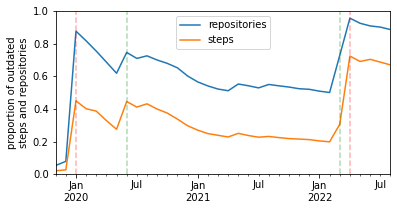

In [90]:
fig, ax = matplotlib.pyplot.subplots()

temp = pd.concat([
    df_lag
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        steps=('step', 'count'), 
        outdated=('outdated', 'sum'),
    )
    .assign(steps=lambda d: d.outdated / d.steps)
    [['steps']]
    ,
    df_lag
    .groupby([pd.Grouper(key='snapshot', freq='M'), 'repository'])
    .agg({'outdated': 'max'})
    .reset_index()
    .groupby(pd.Grouper(key='snapshot', freq='M'))
    .agg(
        repositories=('repository', 'nunique'),
        outdated=('outdated', 'sum'),
    )
    .assign(repositories=lambda d: d.outdated / d.repositories)
    [['repositories']]
], axis=1)

temp[['repositories', 'steps']].plot(ax=ax, color=PALETTE)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of outdated\nsteps and repositories', 
    ylim=(0, 1),
)

# Look at "releases.csv.gz" for the exact dates! (those "coded" have one extra month)
# actions/checkout v2
ax.vlines(pd.to_datetime('2020-01'), 0, 1, colors='r', alpha=0.3, linestyles='dashed')

# actions/setup-python, setup-node, setup-java, setup-go, etc. v2
ax.vlines(pd.to_datetime('2020-06'), 0, 1, colors='g', alpha=0.3, linestyles='dashed')

# actions/setup-python, setup-node, setup-java, setup-go, etc. v3
ax.vlines(pd.to_datetime('2022-03'), 0, 1, colors='g', alpha=0.3, linestyles='dashed')

# actions/checkout v3
ax.vlines(pd.to_datetime('2022-04'), 0, 1, colors='r', alpha=0.3, linestyles='dashed')


savefig(fig, 'lag_outdated')

In [58]:
temp

,steps,repositories
snapshot,,
2019-11-30,0.021240,0.053407
2019-12-31,0.026559,0.078900
2020-01-31,0.449688,0.877217
2020-02-29,0.401525,0.817789
2020-03-31,0.386882,0.754734
2020-04-30,0.328718,0.687220
2020-05-31,0.275411,0.618912
2020-06-30,0.445516,0.746701
2020-07-31,0.411459,0.709902


## Technical lag

### For steps

### For repositories

## Opportunity lag

### For steps

### For repositories